In [1]:
import os
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from loss import custom_loss

from loss import *
from models import *
import utils
import OptimizedDataGenerator as DG

pi = 3.14159265359

maxval=1e9
minval=1e-9

2024-08-29 20:55:35.836856: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 20:55:35.836944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 20:55:35.838095: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 20:55:35.845141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-29 20:55:38.339070: W tensorflow/compiler/tf2

In [2]:
# compiles model
model=CreateModel((13,21,2),n_filters=5,pool_size=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 21, 2)]       0         
                                                                 
 q_separable_conv2d (QSepar  (None, 11, 19, 5)         33        
 ableConv2D)                                                     
                                                                 
 q_activation (QActivation)  (None, 11, 19, 5)         0         
                                                                 
 q_conv2d (QConv2D)          (None, 11, 19, 5)         30        
                                                                 
 q_activation_1 (QActivatio  (None, 11, 19, 5)         0         
 n)                                                              
                                                                 
 average_pooling2d (Average  (None, 3, 6, 5)           0     

In [3]:
model.compile(
    optimizer=tf.keras.optimizers.Nadam(learning_rate=1e-3),
    loss=custom_loss
)

In [4]:
fingerprint = '17ce0174'
base_dir = f'./trained_models/model-{fingerprint}-checkpoints'
checkpoint_files = [os.path.join(base_dir, f) for f in os.listdir(base_dir) if f.endswith('.hdf5')]
latest_checkpoint = max(checkpoint_files, key=os.path.getmtime)
training_cp_path = os.path.join(base_dir, 'training_log.csv')
training_history = pd.read_csv(training_cp_path)

In [5]:
print(f"Loading model from {latest_checkpoint}")
model.load_weights(latest_checkpoint)
  

Loading model from ./trained_models/model-17ce0174-checkpoints/weights.81-t-4827.86-v-5628.91.hdf5


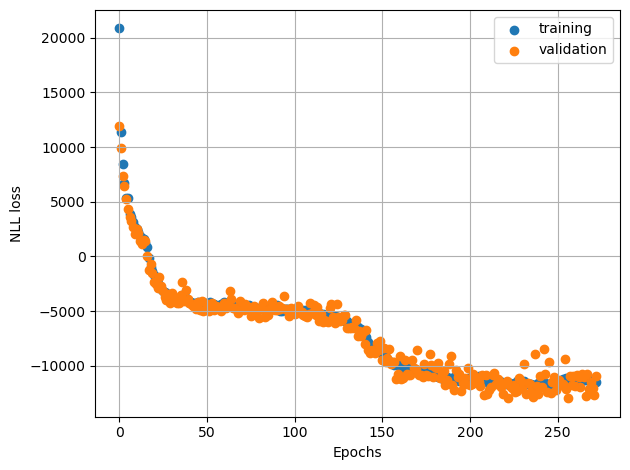

In [6]:
plt.scatter(training_history['epoch'], training_history['loss'])
plt.scatter(training_history['epoch'], training_history['val_loss'])
plt.legend(['training', 'validation'])
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('NLL loss')
plt.tight_layout() 

plt.savefig(os.path.join(base_dir,'training_hist.png'))
plt.show()

In [7]:
training_history

,epoch,loss,val_loss
0,0,20830.728516,11917.625977
1,1,11378.769531,9934.482422
2,2,8456.752930,7329.186035
3,3,6688.137207,6453.405273
4,4,5352.458984,5275.599609
...,...,...,...
268,268,-11249.858398,-12145.417969
269,269,-11461.197266,-11450.845703
270,270,-11599.998047,-12065.346680
271,271,-11312.228516,-12663.962891


In [8]:
tfrecords_dir_val = "/depot/cms/users/kuang14/Smart_Pixel/tf_records/tfrecords_2t_dataset18_bs5000_val"
test_generator = DG.OptimizedDataGenerator(
    load_from_tfrecords_dir = tfrecords_dir_val,
    quantize = True
)

In [9]:
# predicts test data
p_test = model.predict(test_generator)

1028/1028 [==============================] - 145s 141ms/step


In [10]:
complete_truth = None
for _, y in tqdm(test_generator):
        if complete_truth is None:
            complete_truth = y
        else:
            complete_truth = np.concatenate((complete_truth, y), axis=0)

100%|██████████| 1028/1028 [02:24<00:00,  7.13it/s]


In [11]:
# creates df with all predicted values and matrix elements - 4 predictions, all 10 unique matrix elements
df = pd.DataFrame(p_test,columns=['x','M11','y','M22','cotA','M33','cotB','M44','M21','M31','M32','M41','M42','M43'])

# stores all true values in same matrix as xtrue, ytrue, etc.
df['xtrue'] = complete_truth[:,0]
df['ytrue'] = complete_truth[:,1]
df['cotAtrue'] = complete_truth[:,2]
df['cotBtrue'] = complete_truth[:,3]
df['M11'] = minval+tf.math.maximum(df['M11'], 0)
df['M22'] = minval+tf.math.maximum(df['M22'], 0)
df['M33'] = minval+tf.math.maximum(df['M33'], 0)
df['M44'] = minval+tf.math.maximum(df['M44'], 0)

df['sigmax'] = abs(df['M11'])
df['sigmay'] = np.sqrt(df['M21']**2 + df['M22']**2)
df['sigmacotA'] = np.sqrt(df['M31']**2+df['M32']**2+df['M33']**2)
df['sigmacotB'] = np.sqrt(df['M41']**2+df['M42']**2+df['M43']**2+df['M44']**2)

# calculates residuals for x, y, cotA, cotB
residuals = df['xtrue'] - df['x']
residualsy = df['ytrue'] - df['y']
residualsA = df['cotAtrue'] - df['cotA']
residualsB = df['cotBtrue'] - df['cotB']

# stores results as csv
df.to_csv("test_4x4.csv",header=True,index=False)

# residuals (mean, stdv)

In [37]:
# x
(np.mean(residuals)*75,np.std(residuals)*75)

(-4.476368520408869, 99.24085736274719)

In [38]:
# y
(np.mean(residualsy)*18.75,np.std(residualsy)*18.75)

(-2.58440924808383, 5.481731705367565)

In [39]:
# cotA
(np.mean(residualsA)*8,np.std(residualsA)*8)

(0.09256192296743393, 3.773186206817627)

In [40]:
# cotB
(np.mean(residualsB)*0.5,np.std(residualsB)*0.5)

(0.07522883266210556, 0.17952722311019897)

# x residuals

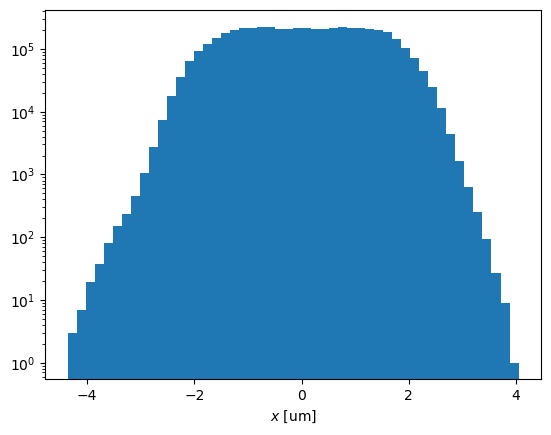

In [41]:
#plt.hist(p_test[:,0],bins=np.linspace(-3,3,50))
plt.hist(p_test[:, 0], bins=50); plt.autoscale(enable=True, axis='x')
plt.yscale('log')
plt.xlabel(r'$x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_dist.png')
plt.savefig(save_fig_path)

plt.show()

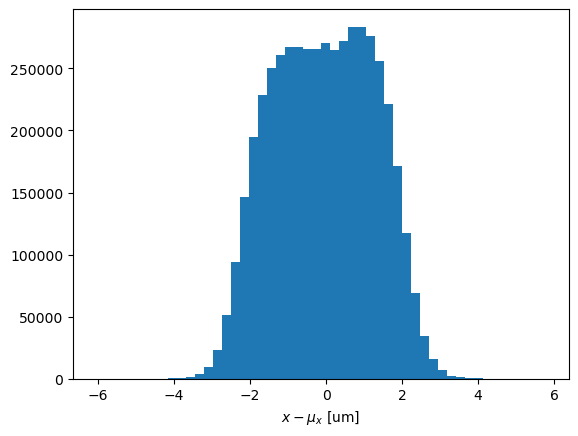

In [42]:
#plt.hist(residuals,bins=np.linspace(-1.5,1.5,50))
plt.hist(residuals, bins=50); plt.autoscale(enable=True, axis='x')
#plt.yscale('Log')
plt.xlabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

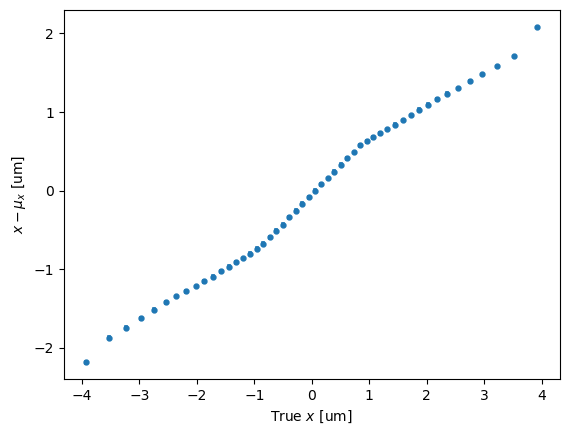

In [43]:
#x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=np.linspace(-1.5,1.5,50), fit_reg=None, marker='.')
x = sns.regplot(x=df['xtrue'], y=(df['xtrue']-df['x']), x_bins=50, fit_reg=None, marker='.')
plt.xlabel(r'True $x$ [um]')
plt.ylabel(r'$x-\mu_x$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# y residuals

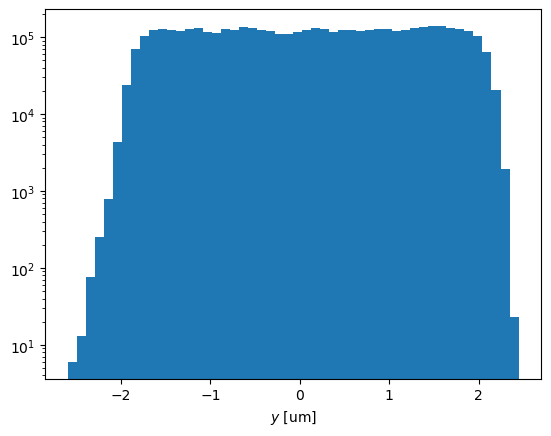

In [44]:
#plt.hist(p_test[:,2],bins=np.linspace(-1.5,1.5,50))
plt.hist(p_test[:, 2], bins=50); plt.autoscale(enable=True, axis='x')

plt.yscale('log')
plt.xlabel(r'$y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_dist.png')
plt.savefig(save_fig_path)

plt.show()

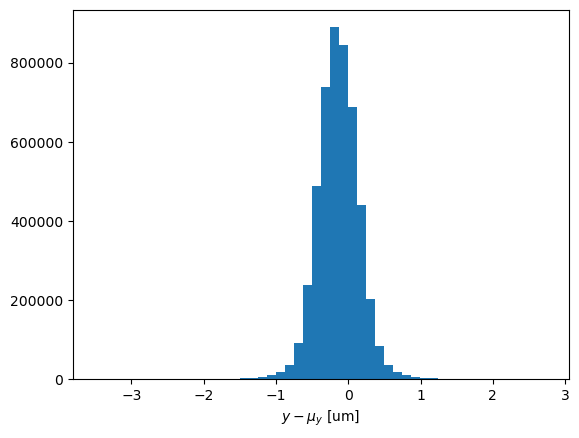

In [45]:
#plt.hist(residualsy,bins=np.linspace(-1,1,50))
plt.hist(residualsy, bins=50); plt.autoscale(enable=True, axis='x')


#plt.yscale('Log')
plt.xlabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'y_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

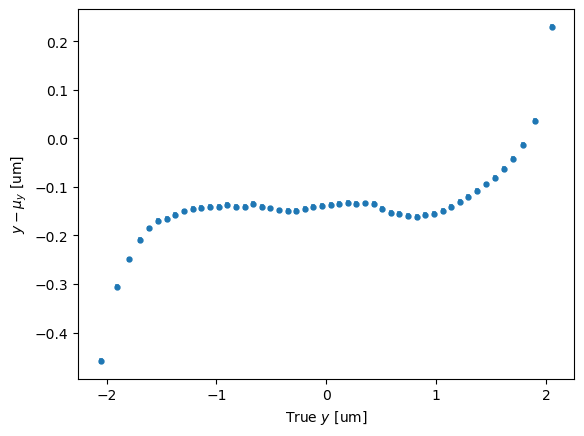

In [46]:
#x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=np.linspace(-1,1,50), fit_reg=None, marker='.')
x = sns.regplot(x=df['ytrue'], y=(df['ytrue']-df['y']), x_bins=50, fit_reg=None, marker='.')


plt.xlabel(r'True $y$ [um]')
plt.ylabel(r'$y-\mu_y$ [um]')

save_fig_path = os.path.join(base_dir, 'x_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotA residuals

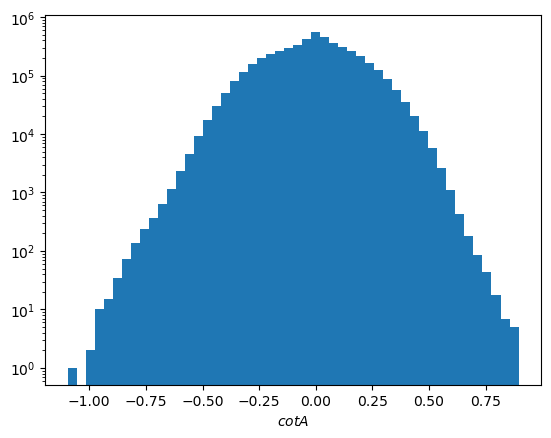

In [47]:
#plt.hist(p_test[:,4],bins=np.linspace(-1.25,1.25,50))
plt.hist(p_test[:, 4], bins=50); plt.autoscale(enable=True, axis='x')


plt.yscale('log')
plt.xlabel(r'$cotA$')

save_fig_path = os.path.join(base_dir, 'cotA_dist.png')
plt.savefig(save_fig_path)

plt.show()

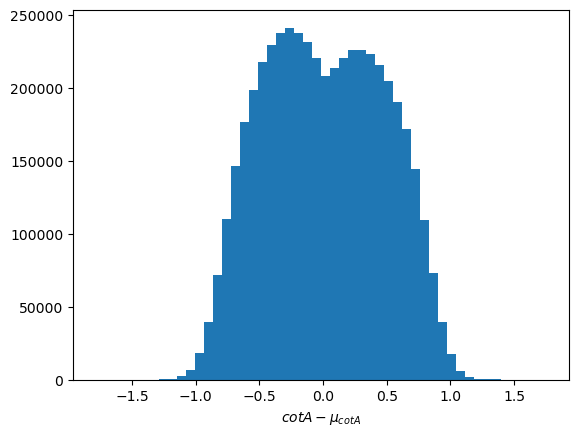

In [48]:
#plt.hist(residualsA,bins=np.linspace(-0.5,0.5,50))
plt.hist(residualsA, bins=50); plt.autoscale(enable=True, axis='x')
#plt.yscale('Log')
plt.xlabel(r'$cotA-\mu_{cotA}$')

save_fig_path = os.path.join(base_dir, 'cotA_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

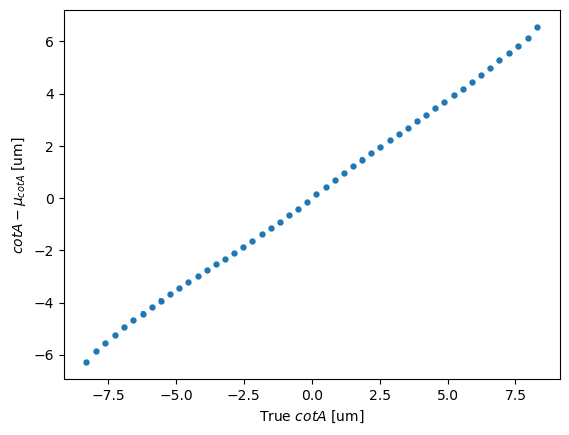

In [49]:
#x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=np.linspace(-8,8,50), fit_reg=None, marker='.')
x = sns.regplot(x=df['cotAtrue']*8, y=(df['cotAtrue']-df['cotA'])*8, x_bins=50, fit_reg=None, marker='.')

plt.xlabel(r'True $cotA$ [um]')
plt.ylabel(r'$cotA-\mu_{cotA}$ [um]')

save_fig_path = os.path.join(base_dir, 'cotA_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# cotB residuals

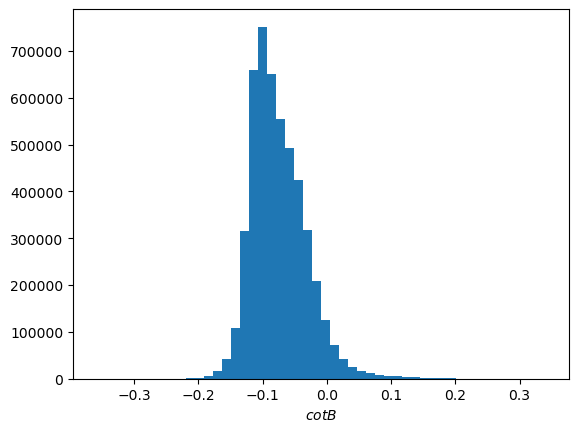

In [50]:
#plt.hist(p_test[:,6]*0.5,bins=np.linspace(-1,1,50))
plt.hist(p_test[:, 6]*0.5, bins=50); plt.autoscale(enable=True, axis='x')
#plt.yscale('Log')
plt.xlabel(r'$cotB$')

save_fig_path = os.path.join(base_dir, 'cotB_dist.png')
plt.savefig(save_fig_path)

plt.show()

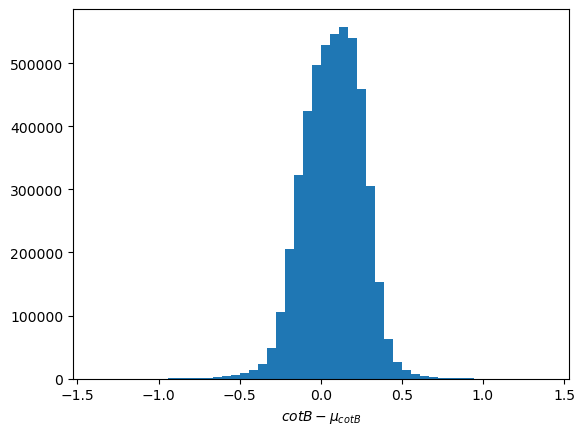

In [51]:
#plt.hist(residualsB*0.5,bins=np.linspace(-1,1,50))
plt.hist(residualsB*0.5, bins=50); plt.autoscale(enable=True, axis='x')
#plt.yscale('Log')
plt.xlabel(r'$cotB-\mu_{cotB}$')

save_fig_path = os.path.join(base_dir, 'cotB_res_dist.png')
plt.savefig(save_fig_path)

plt.show()

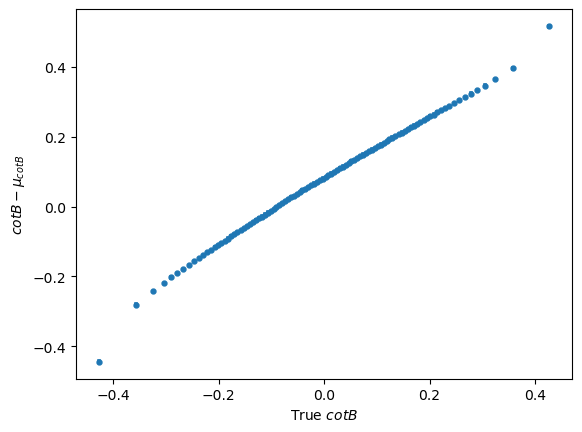

In [52]:
#x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=np.linspace(-1,1,100), fit_reg=None, marker='.')
x = sns.regplot(x=df['cotBtrue']*0.5, y=(df['cotBtrue']-df['cotB'])*0.5, x_bins=100, fit_reg=None, marker='.')
plt.xlabel(r'True $cotB$')
plt.ylabel(r'$cotB-\mu_{cotB} $')

save_fig_path = os.path.join(base_dir, 'cotB_vs_res.png')
plt.savefig(save_fig_path)

plt.show()

# pull

In [62]:
df['pullx'] = (df['xtrue']-df['x'])/df['sigmax']
df['pully'] = (df['ytrue']-df['y'])/df['sigmay']
df['pullcotA'] = (df['cotAtrue']-df['cotA'])/df['sigmacotA']
df['pullcotB'] = (df['cotBtrue']-df['cotB'])/df['sigmacotB']

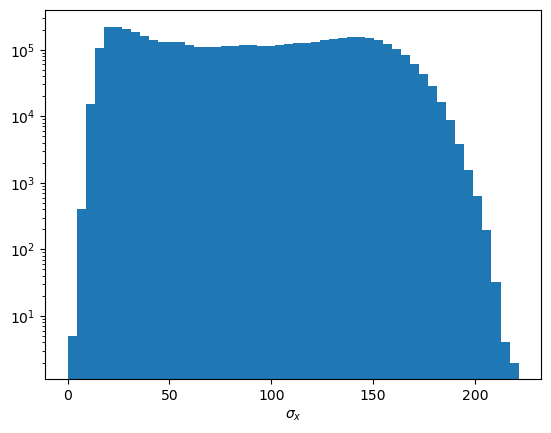

In [63]:
#plt.hist(df['sigmax'] * 75,bins=np.linspace(0,35,50))
plt.hist(df['sigmax'] * 75, bins=50); plt.autoscale(enable=True, axis='x')

plt.xlabel('$\sigma_{x}$')
plt.yscale('log')

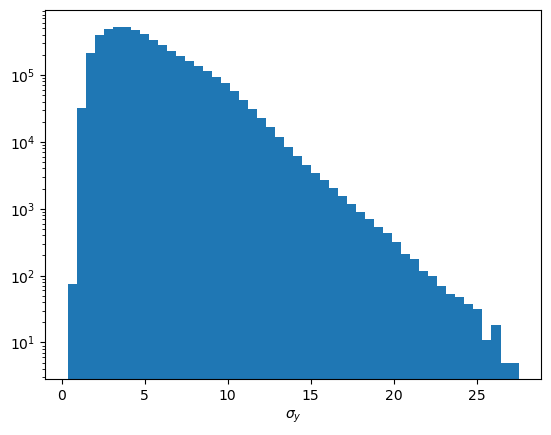

In [64]:
#plt.hist(df['sigmay']* 18.75,bins=np.linspace(0,6,50))
plt.hist(df['sigmay'] * 18.75, bins=50); plt.autoscale(enable=True, axis='x')

plt.xlabel('$\sigma_{y}$')
plt.yscale('log')

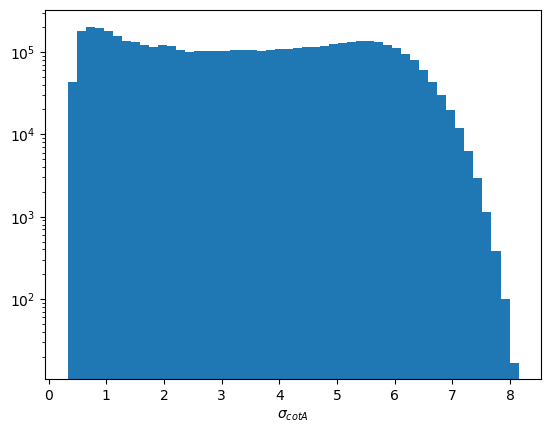

In [65]:
#plt.hist(df['sigmacotA'] * 8,bins=np.linspace(0,1.0,50))
plt.hist(df['sigmacotA'] * 8, bins=50); plt.autoscale(enable=True, axis='x')

plt.xlabel('$\sigma_{cotA}$')
plt.yscale('log')

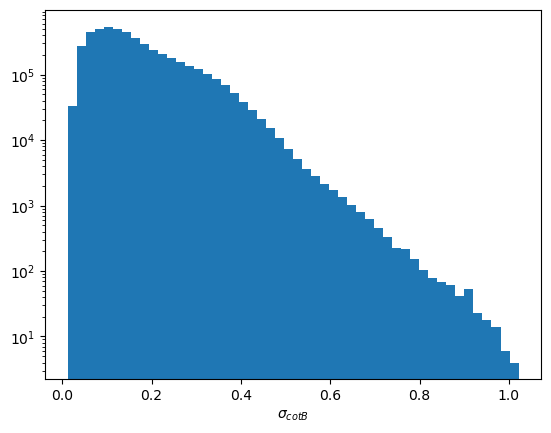

In [66]:
#plt.hist(df['sigmacotB'] * 0.5 ,bins=np.linspace(0,0.25,50))
plt.hist(df['sigmacotB'] * 0.5, bins=50); plt.autoscale(enable=True, axis='x')

plt.xlabel('$\sigma_{cotB}$')
plt.yscale('log')

In [67]:
from scipy.optimize import curve_fit

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))

def pull_plot(ax, var, name):
    
    h = ax.hist(df[var],bins=np.linspace(-5,5,50),histtype='step')
    ax.set_xlabel(name)
    ax.set_yscale('log')

    ydata = h[0]
    xdata = h[1][:-1]+3/50.

    pars, cov = curve_fit(gauss,xdata,ydata)

    xbins = np.linspace(-5,5,100)
    ax.plot(xbins,gauss(xbins,pars[0],pars[1],pars[2]),color='black')
    #ax.set_ylim(0.5,100000)
    ax.set_ylim(0.5,1000000)

    print('Mean',pars[1])
    print('Sigma',pars[2])
    
    ax.text(-5,2000,"$\mu$="+str(round(pars[1],2)))
    ax.text(-5,1000,"$\sigma$="+str(round(abs(pars[2]),2)))

Mean -0.10686358023872691
Sigma 1.3036847631538704
Mean -0.7320052069568239
Sigma -0.8170056358878389
Mean -0.016449750984041694
Sigma -1.329239579076156
Mean 0.8709141451441174
Sigma 0.3055110032077946


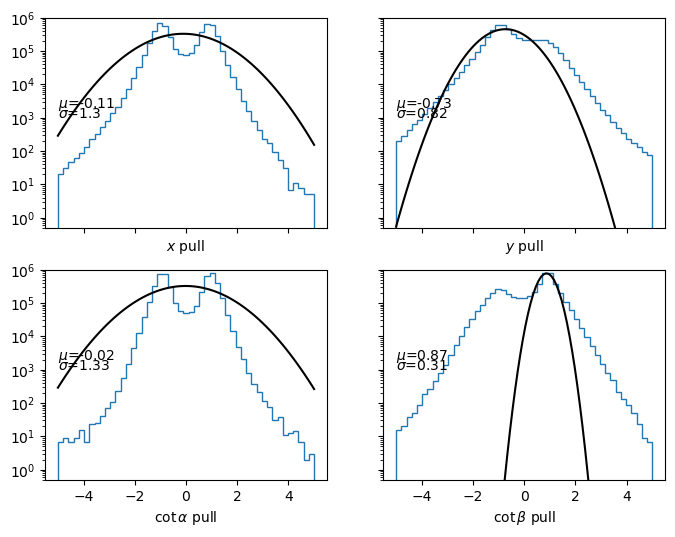

In [68]:
fig, axes = plt.subplots(2,2,sharex=True,sharey=True,figsize=(8,6))
pull_plot(axes[0][0],'pullx',r'$x$ pull')
pull_plot(axes[0][1],'pully',r'$y$ pull')
pull_plot(axes[1][0],'pullcotA',r'$\cot\alpha$ pull')
pull_plot(axes[1][1],'pullcotB',r'$\cot\beta$ pull')

save_fig_path = os.path.join(base_dir, 'Pull.png')
plt.savefig(save_fig_path)

plt.show()

In [69]:
def residual_plot(ax, thisdf, var1, var2, name, scaling=1.0):
    
    nbins = 15
    
    var1_scaled = thisdf[var1] * scaling
    var2_scaled = thisdf[var2] * scaling
    residual_scaled = var1_scaled - var2_scaled
    
    xmin = np.min(var1_scaled)
    xmax = np.max(var1_scaled)
    
    step = 1.0*(xmax-xmin)/nbins
    
    x = sns.regplot(x=var1_scaled, y=residual_scaled, x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = residual_scaled
    print(var1)
    
    means = []
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
        downbar += [means[i] - np.mean(thisdf['sigma'+var2][(var1_scaled>xmin + i*step) & (var1_scaled<xmin + (i+1)*step)] * scaling)]
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

def inverse_cot(cota):
    a = np.arctan(1.0/cota)
    a[np.where(a<0)] = a[np.where(a<0)] + pi
    return a    

def residual_plot_deg(ax, thisdf, var1, var2, name, scaling=1.0):
    # positions
    if 'cot' not in var1:
        residual_plot(ax, thisdf, var1, var2, name, scaling=scaling)
        return

    thisdf['angle'] = inverse_cot(thisdf[var2].values * scaling)*180/pi
    
    thisdf['angleup'] = abs(inverse_cot((thisdf[var2].values + thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angledown'] = abs(inverse_cot((thisdf[var2].values - thisdf['sigma'+var2].values) * scaling)*180/pi - thisdf['angle'])
    thisdf['angletrue'] = inverse_cot(thisdf[var1].values * scaling)*180/pi
        
    var1 = 'angletrue'
    var2 = 'angle'
    
    nbins = 15
    xmin = np.min(thisdf[var1])
    xmax = np.max(thisdf[var1])
    
    step = 1.0*(xmax-xmin)/nbins
        
    x = sns.regplot(x=thisdf[var1], y=(thisdf[var1]-thisdf[var2]), x_bins=np.linspace(xmin,xmax,nbins), fit_reg=None, marker='.', ax=ax)
    ax.set_xlabel('True ' + name)
    ax.set_ylabel('True - predicted ' + name)
    
    thisdf['residual'+var2] = (thisdf[var1]-thisdf[var2])
    print(var1)
    
    means = []    
    upbar = []
    downbar = []
    for i in range(0,nbins):
        means += [np.mean(thisdf['residual'+var2][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        upbar += [means[i] + np.mean(thisdf['angleup'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
        downbar += [means[i] - np.mean(thisdf['angledown'][(thisdf[var1]>xmin + i*step) & (thisdf[var1]<xmin + (i+1)*step)])]
    #ax.scatter(x=np.linspace(xmin,xmax,nbins),y=means)
    ax.fill_between(x=np.linspace(xmin,xmax,nbins),y1=upbar,y2=downbar, alpha=0.2)

xtrue
ytrue


/tmp/ipykernel_602832/2844183014.py:31: RuntimeWarning: divide by zero encountered in divide
  a = np.arctan(1.0/cota)


angletrue
angletrue


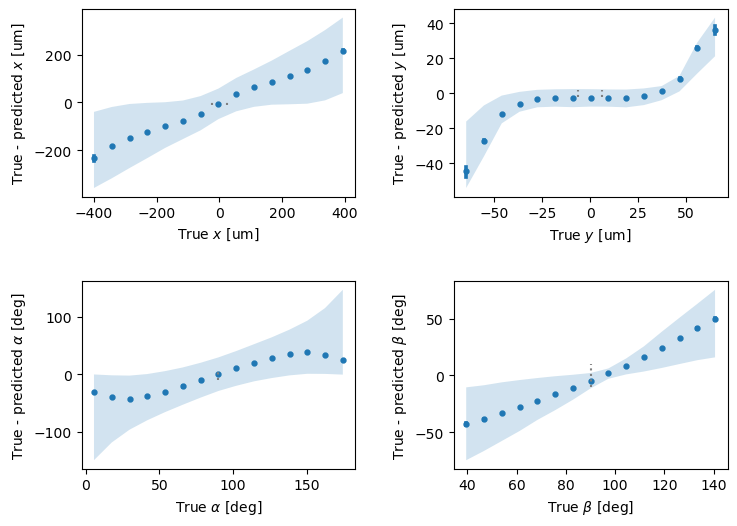

In [70]:
fig, axes = plt.subplots(2,2,figsize=(8,6))
fig.tight_layout(pad=4.0)
residual_plot(axes[0][0],df,'xtrue','x',r'$x$ [um]', scaling=75.0)
axes[0][0].plot([-25,-25],[-10,10],color='gray',linestyle=':')
axes[0][0].plot([25,25],[-10,10],color='gray',linestyle=':')
residual_plot(axes[0][1],df,'ytrue','y',r'$y$ [um]', scaling=18.75)
axes[0][1].plot([-6.25,-6.25],[-2,2],color='gray',linestyle=':')
axes[0][1].plot([6.25,6.25],[-2,2],color='gray',linestyle=':')
residual_plot_deg(axes[1][0],df,'cotAtrue','cotA',r'$\alpha$ [deg]', scaling=8.0)
axes[1][0].plot([90,90],[-10,10],color='gray',linestyle=':')
residual_plot_deg(axes[1][1],df,'cotBtrue','cotB',r'$\beta$ [deg]', scaling=0.5)
axes[1][1].plot([90,90],[-10,10],color='gray',linestyle=':')

save_fig_path = os.path.join(base_dir, 'summary.png')
plt.savefig(save_fig_path)